In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import cv2

# **Funções Auxiliares**

In [2]:
def bgr_to_gray(img):
    b = img[:,:,0].astype(float)
    g = img[:,:,1].astype(float)
    r = img[:,:,2].astype(float)
    
    gray = (0.2989 * r + 0.5870 * g + 0.1140 * b)
    gray_image = cv2.merge([gray, gray, gray])
    
    return gray_image.astype(img.dtype)

In [3]:
def bgr_to_rgb(img):
    b = img[:,:,0]
    g = img[:,:,1]
    r = img[:,:,2]
    return cv2.merge([r, g, b])

In [4]:
def bgr_to_ycrcb(img):
    img = img.astype(np.float32)
    
    B = img[:, :, 0]
    G = img[:, :, 1]
    R = img[:, :, 2]

    # Compute Y, Cr, and Cb using the formulas
    Y  = 0.299 * R + 0.587 * G + 0.114 * B
    Cr = (R - Y) * 0.713 + 128
    Cb = (B - Y) * 0.564 + 128

    # Stack into a 3-channel image
    ycrcb = cv2.merge([Y, Cr, Cb])
    return np.clip(ycrcb, 0, 255).astype(img.dtype)

In [5]:
def ycrcb_to_bgr(ycrcb):
    ycrcb = ycrcb.astype(np.float32)
    
    Y  = ycrcb[:, :, 0]
    Cr = ycrcb[:, :, 1] - 128
    Cb = ycrcb[:, :, 2] - 128

    R = Y + 1.403 * Cr
    G = Y - 0.344 * Cb - 0.714 * Cr
    B = Y + 1.773 * Cb

    bgr = cv2.merge([B, G, R])
    return np.clip(bgr, 0, 255).astype(ycrcb.dtype)


In [6]:
def show_diff(img_0, img_1, axis=False):
    img_0 = img_0*255.0
    img_1 = img_1*255.0

    img_0 = img_0.astype(np.uint8)
    img_1 = img_1.astype(np.uint8)
    
    plt.figure(figsize=(12,6))
    
    plt.subplot(1,2,1)
    plt.imshow(bgr_to_rgb(img_0))
    plt.axis(axis)
    plt.title('Original')

    plt.subplot(1,2,2)
    plt.imshow(bgr_to_rgb(img_1))
    plt.axis(axis)
    plt.title("Modificada")

    plt.tight_layout()
    plt.show()

# **Compositing and Matting**

In [7]:
bia_img = cv2.imread("fotos/1.jpg")
# bia_img = cv2.resize(bia_img,None, fx=0.5, fy=0.5)
height, width = bia_img.shape[0], bia_img.shape[1]
castelo_img = cv2.resize(cv2.imread('fotos/castelo.jpg'), (width, height))

In [8]:
def compose(img_0, img_1, a):
    comp = img_0.astype(np.float32) * a + (1 - a) * img_1.astype(np.float32) 
    comp = comp.astype(np.uint8)
    return comp

In [9]:
a = 0.5
comp = (1 - a) * bia_img + a*castelo_img
comp = comp.astype(np.uint8)

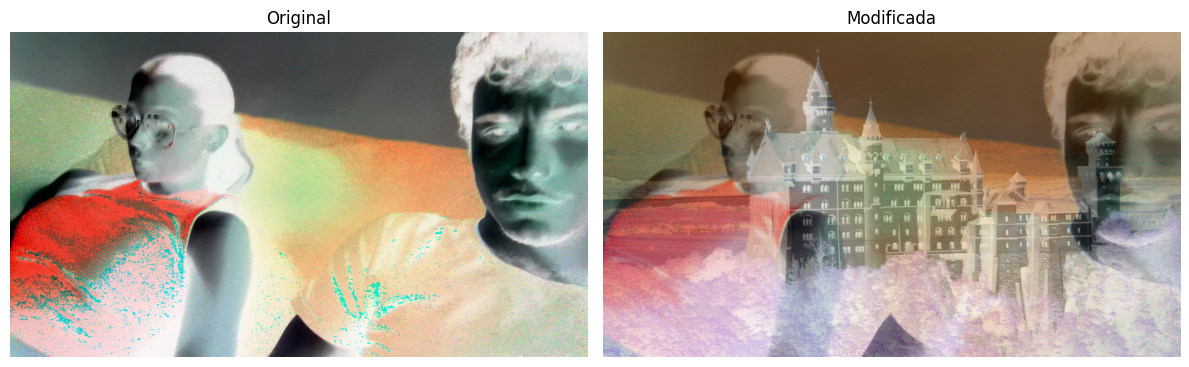

In [10]:
show_diff(bia_img, comp)

# **Histogram**

In [11]:
def histogram(img):
    img=img.astype(np.uint8)
    hist_b = np.bincount(img[:,:,0].flatten(), minlength=256)
    hist_g = np.bincount(img[:,:,1].flatten(), minlength=256)
    hist_r = np.bincount(img[:,:,2].flatten(), minlength=256)

    return (hist_b, hist_g, hist_r)

In [12]:
def plot_histogram(hist_bgr, img=None):
    if img is None: 
        plt.plot(hist_bgr[0], color='blue')
        plt.plot(hist_bgr[1], color='green')
        plt.plot(hist_bgr[2], color='red')
        plt.title('histogram')
        
    else:
        plt.figure(figsize=(12,6))
        
        plt.subplot(1,2,2)
        plt.plot(hist_bgr[0], color='blue')
        plt.plot(hist_bgr[1], color='green')
        plt.plot(hist_bgr[2], color='red')
        plt.title('histogram')

        plt.subplot(1,2,1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title("Imagem")

    plt.show()

In [13]:
def equalize_hist_img(img):
    hist_y, _, _ = histogram(img)
    cdf_y = hist_y.cumsum()
    cdf_y = cdf_y / cdf_y[-1]

    equalized_map_y = np.round(255 * cdf_y).astype('uint8')

    y_eq = equalized_map_y[img[:, :, 0]]
    cr = img[:, :, 1]
    cb = img[:, :, 2]
    return cv2.merge([y_eq, cr, cb])
       

In [14]:
# file_name = "Gorskii_00171u.jpg"
# castelo_img = cv2.imread(f'fotos/{file_name}')
# castelo_ycrcb = bgr_to_ycrcb(castelo_img)
# castelo_ycrcb_equalized = equalize_hist_img(castelo_ycrcb)
# castelo_brg = ycrcb_to_bgr(castelo_ycrcb_equalized)
# a = 0.7
# castelo_brg_equalized = compose(castelo_brg, castelo_img, a)

In [15]:
cv2.imwrite(f'fotos/{file_name}_melhor.jpg', castelo_brg)
cv2.imwrite(f'fotos/{file_name}_melhor_compose.jpg', castelo_brg_equalized)
show_diff(castelo_img, castelo_brg_equalized)

NameError: name 'file_name' is not defined

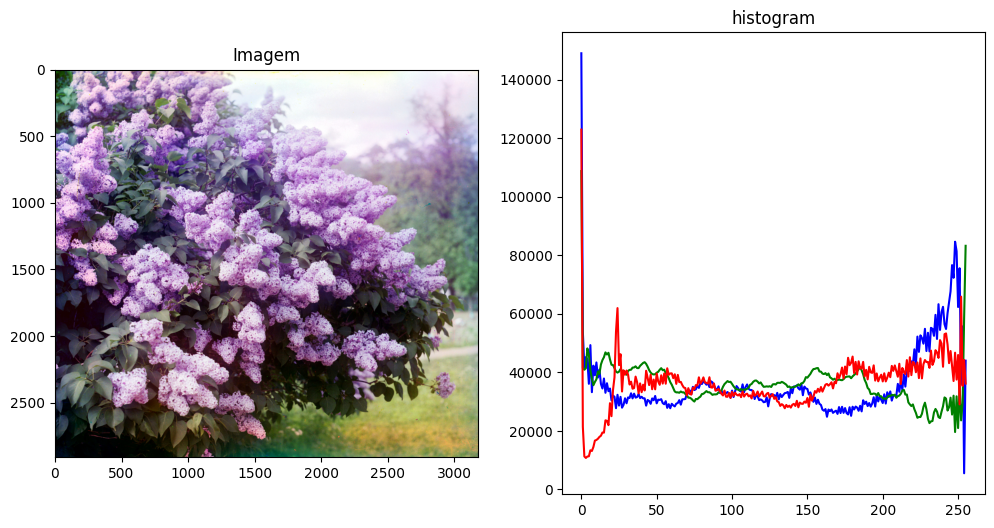

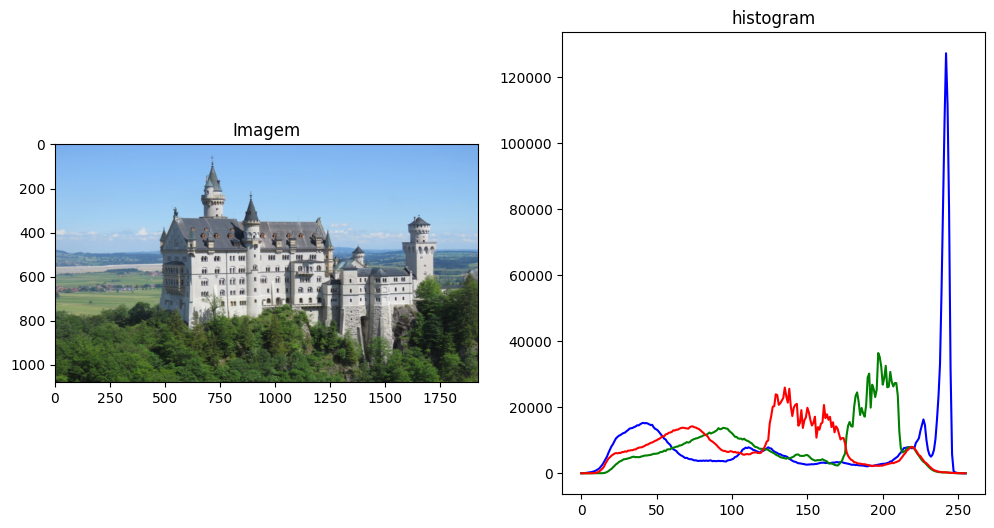

In [ ]:
plot_histogram(histogram(castelo_brg_equalized), castelo_brg_equalized)
plot_histogram(histogram(castelo_img), castelo_img)

# **Linear Filtering.**

In [16]:
def horizontal_filter(img, kernel, plot=False, normalized=True):
    # Cria uma imagem temporária para armazenar o resultado
    temp_image_h = np.zeros_like(img, dtype=np.float32)
    # Itera sobre os canais de cor (B, G, R)
    for channel in range(3):
        if kernel.shape[0] == 3:
            kernel_channel = kernel[channel]
            # print(kernel_channel)
        else:
            kernel_channel = kernel[0]
        # Aplica a convolução em cada linha da imagem
        for i in range(img.shape[0]):
            temp_image_h[i, :, channel] = np.convolve(img[i, :, channel], kernel_channel, mode='same')
        # Exibe a imagem filtrada se necessário
        if plot: 
            plt.subplot(2,3,channel+1)
            plt.imshow(bgr_to_rgb(temp_image_h))
            plt.axis(False)
    # Atualiza img_filtered com o resultado horizontal
    if normalized: img = temp_image_h.astype(np.uint8) 
    else: img = temp_image_h 

    return img

In [17]:
def vertical_filter(img, kernel, plot=False, normalized=True):
    # Cria uma imagem temporária para armazenar o resultado
    temp_image_v = np.zeros_like(img, dtype=np.float32)
    # Itera sobre os canais de cor (B, G, R)
    for channel in range(3):
        if kernel.shape[0] == 3:
            kernel_channel = kernel[channel]
        else:
            kernel_channel = kernel[0]
        # Aplica a convolução em cada coluna da imagem
        for j in range(img.shape[1]):
            temp_image_v[:, j, channel] = np.convolve(img[:, j, channel], kernel_channel, mode='same')
        # Exibe a imagem filtrada se necessário
        if plot: 
            plt.subplot(2,3,channel+4)
            plt.imshow(bgr_to_rgb(temp_image_v))
            plt.axis(False)
    # Atualiza img_filtered com o resultado vertical
    if normalized: img = temp_image_v.astype(np.uint8) 
    else: img = temp_image_v

    return img
    

In [18]:
def linear_filter(img, kernel_horizontal=None, kernel_vertical=None, convert_color_func=None, plot=False, normalized=True):
    # Se uma função de conversão de cor for fornecida, aplica ela à imagem
    if convert_color_func != None:
        img_filtered = convert_color_func(img)
    else:
        # Caso contrário, copia a imagem e converte para float32
        img_filtered = img.copy().astype(np.float32)
    
    # Obtém as dimensões da imagem
    h, w, _ = img_filtered.shape
    
    # Se plot for True, inicia uma figura para visualização
    if plot: plt.figure(figsize=(16,6))

    # Aplica o filtro horizontal, se fornecido
    if kernel_horizontal is not None:      
        img_filtered = horizontal_filter(img_filtered, kernel_horizontal, plot=plot, normalized=normalized)

    # Aplica o filtro vertical, se fornecido
    if kernel_vertical is not None:
        img_filtered = vertical_filter(img_filtered, kernel_vertical, plot=plot, normalized=normalized)

    # Se for para exibir, organiza o layout e mostra a imagem
    if plot: 
        plt.tight_layout()
        plt.show()

    # Garante que os valores da imagem estejam no intervalo [0, 255]
    img_filtered = np.clip(img_filtered, 0, 255)
    
    if normalized: return img_filtered.astype(np.uint8)
    else: return img_filtered



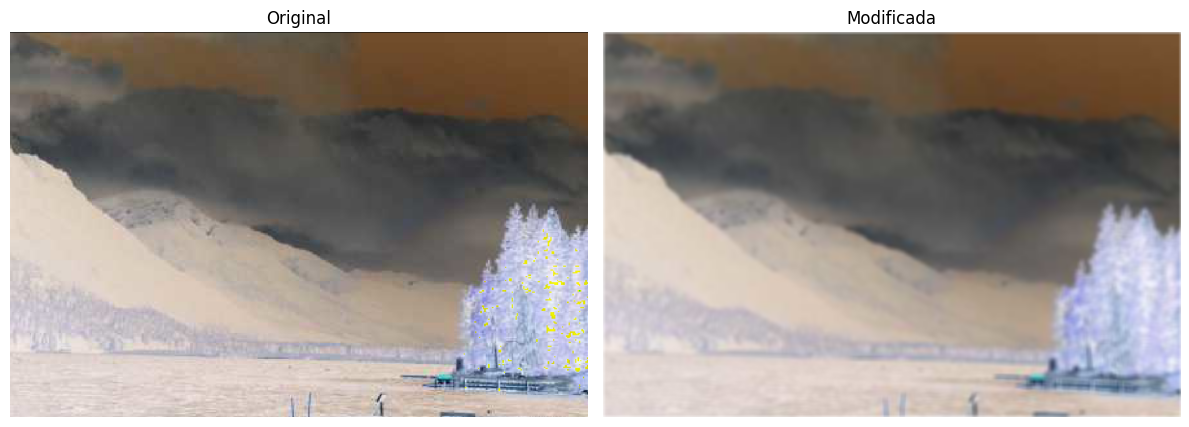

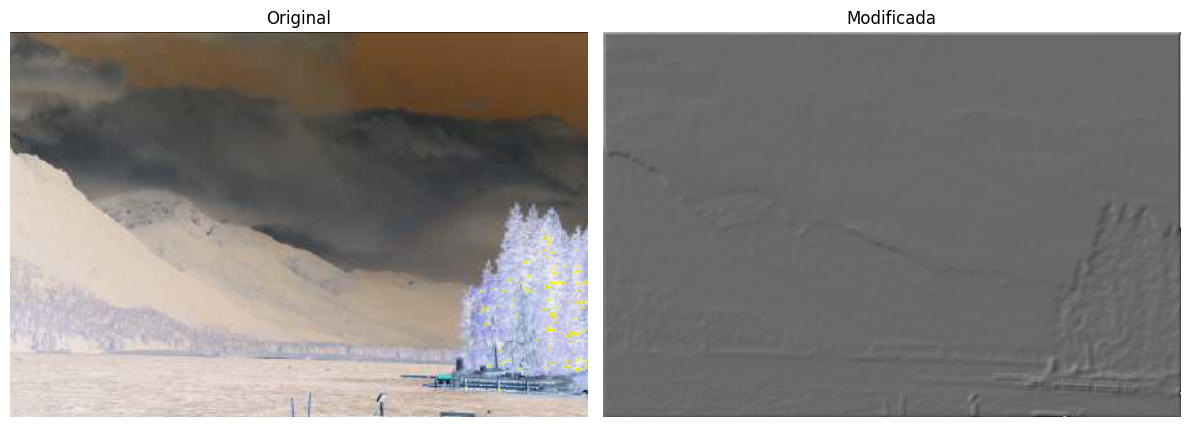

In [19]:
img = cv2.resize(cv2.imread('fotos/rainbow.png'),dsize=None,fx=1, fy=1)
k = 10
blur_kernel = np.array([
    np.ones(k),
    np.ones(k),
    np.ones(k),
]) / k

edge_kernel = np.array([
    [-1,0,1]
])


blurred_img = linear_filter(img, kernel_horizontal=blur_kernel, kernel_vertical=blur_kernel)
edge_imgh = linear_filter(blurred_img, kernel_horizontal=edge_kernel, convert_color_func=bgr_to_gray)
edge_imgv = linear_filter(blurred_img, kernel_vertical=edge_kernel, convert_color_func=bgr_to_gray)

edge_img = np.clip(edge_imgh + edge_imgv+150, 0, 255)

show_diff(img, blurred_img)
show_diff(img, edge_img)


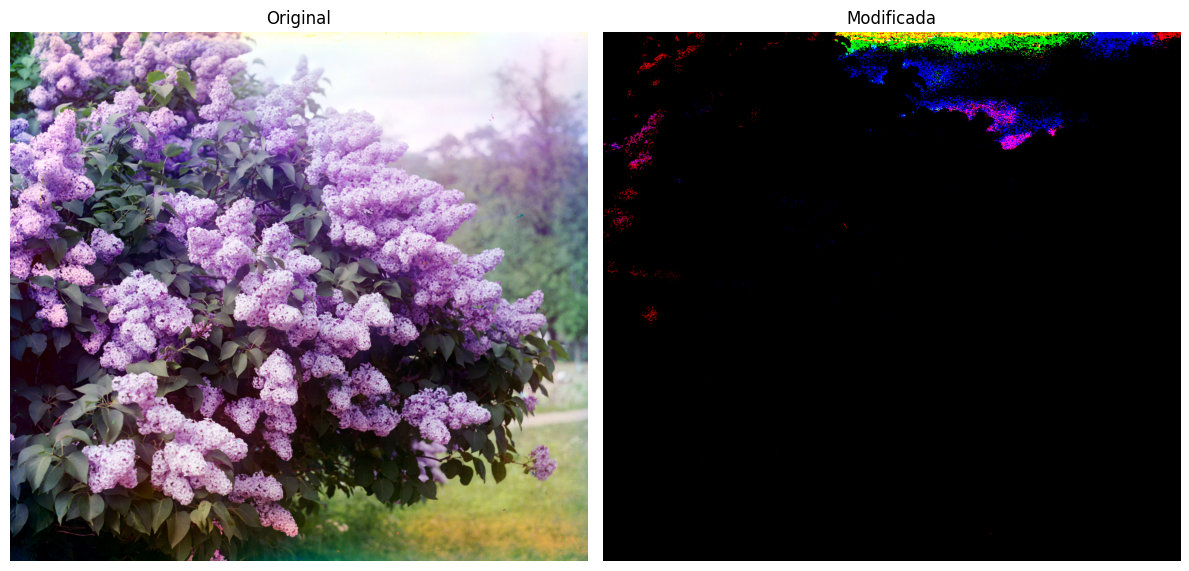

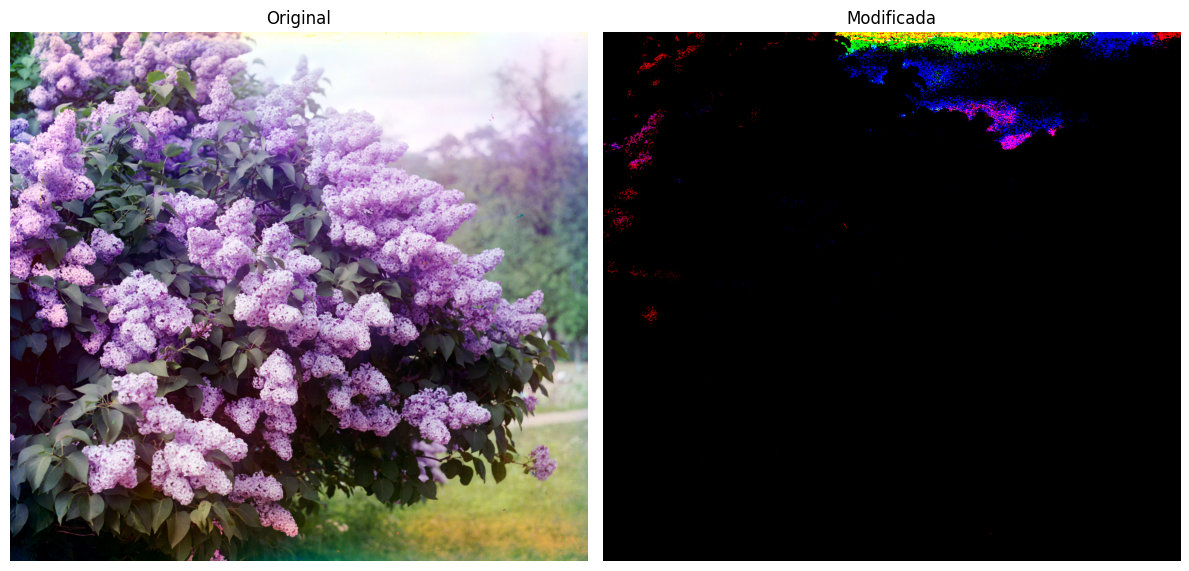

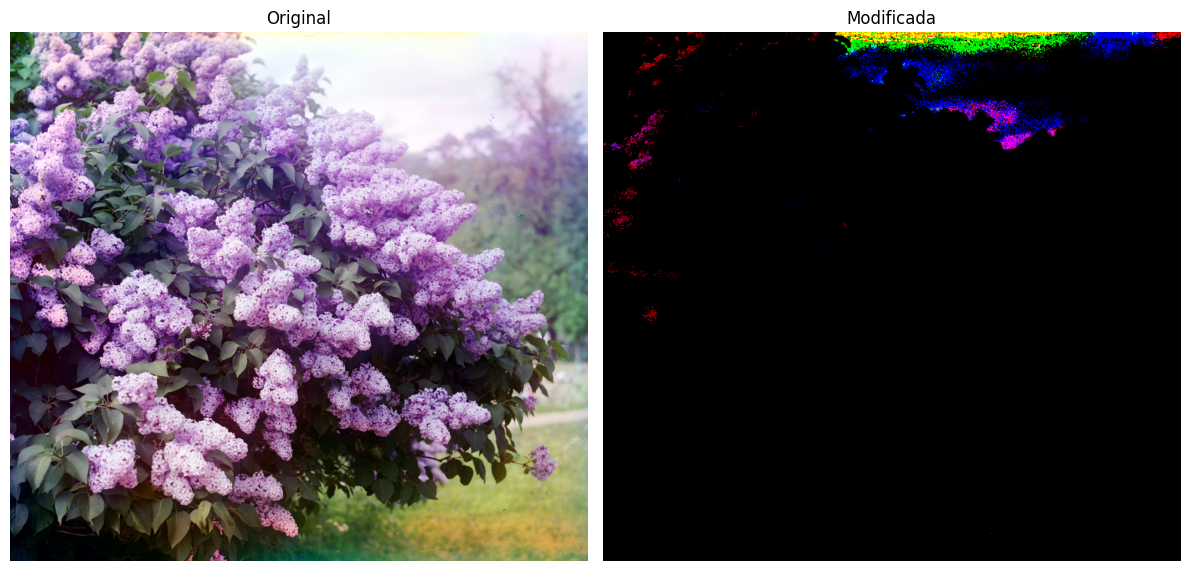

In [20]:
img = cv2.resize(cv2.imread('fotos/Gorskii_00171u.jpg'),dsize=None,fx=1, fy=1) / 255.0
kernel = np.array([
    [0, 1, 0], 
    [0, 1, 0], 
    [0, 1, 0], 
    ]) 
blur_kernel = np.array([[1, 2, 1]]) / 4

# img = linear_filter(img=img, kernel_horizontal=blur_kernel)
# img = linear_filter(img=img, kernel_vertical=blur_kernel)
img_resultv = linear_filter(img=img, kernel_vertical=kernel, convert_color_func=None)
show_diff(img, img_resultv)
img_resulth = linear_filter(img=img, kernel_horizontal=kernel, convert_color_func=None)

show_diff(img, img_resulth)

combined_edges = img_resulth + img_resultv
normalized_edges = np.clip(combined_edges, 0, 255)
show_diff(img, normalized_edges)

# img_result = linear_filter(img=img, kernel_horizontal=kernel_horizontal, kernel_vertical=kernel_horizontal,convert_color_func=bgr_to_gray)
# show_diff(img, img_result)

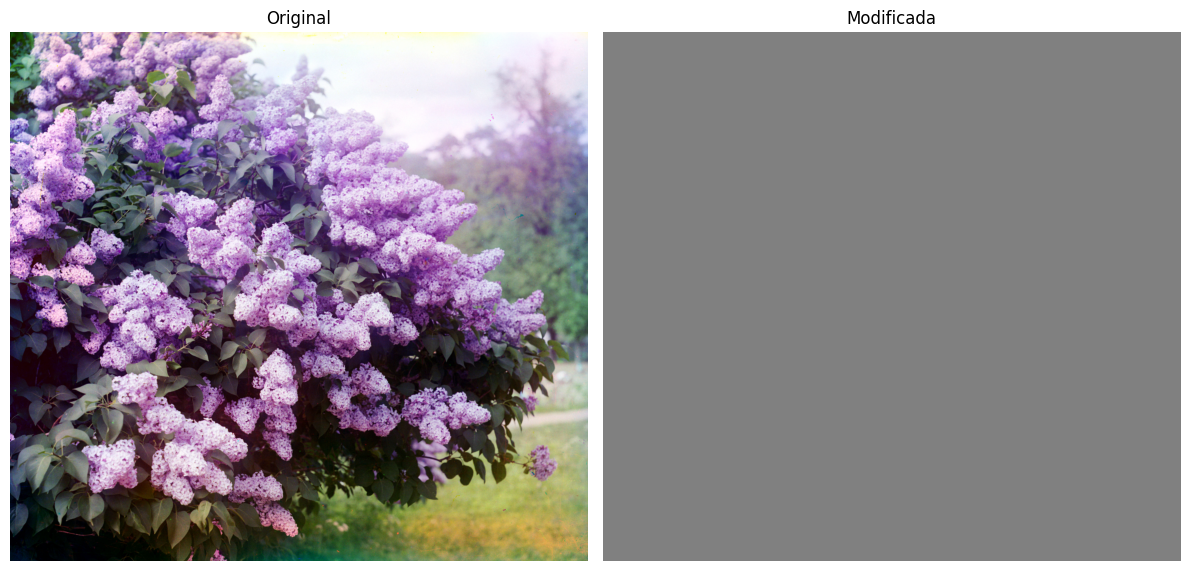

In [21]:
# Create a standard blur kernel and a simple edge detection kernel
blur_kernel = np.array([[1, 2, 1]]) / 4
edge_kernel = np.array([[-1, 0, 1]])

# 1. Apply a light Gaussian blur to reduce noise
img_blurred = linear_filter(img=img, kernel_horizontal=blur_kernel, kernel_vertical=blur_kernel)

# 2. Apply a vertical edge detection filter on the blurred image
img_resultv = linear_filter(img=img_blurred, kernel_vertical=edge_kernel, convert_color_func=bgr_to_gray)

# 3. Apply a horizontal edge detection filter on the blurred image
img_resulth = linear_filter(img=img_blurred, kernel_horizontal=edge_kernel, convert_color_func=bgr_to_gray)

# 4. Combine the results to get all edges
combined_edges = img_resulth + img_resultv
normalized_edges = np.clip(combined_edges + 128, 0, 255)

show_diff(img, normalized_edges)

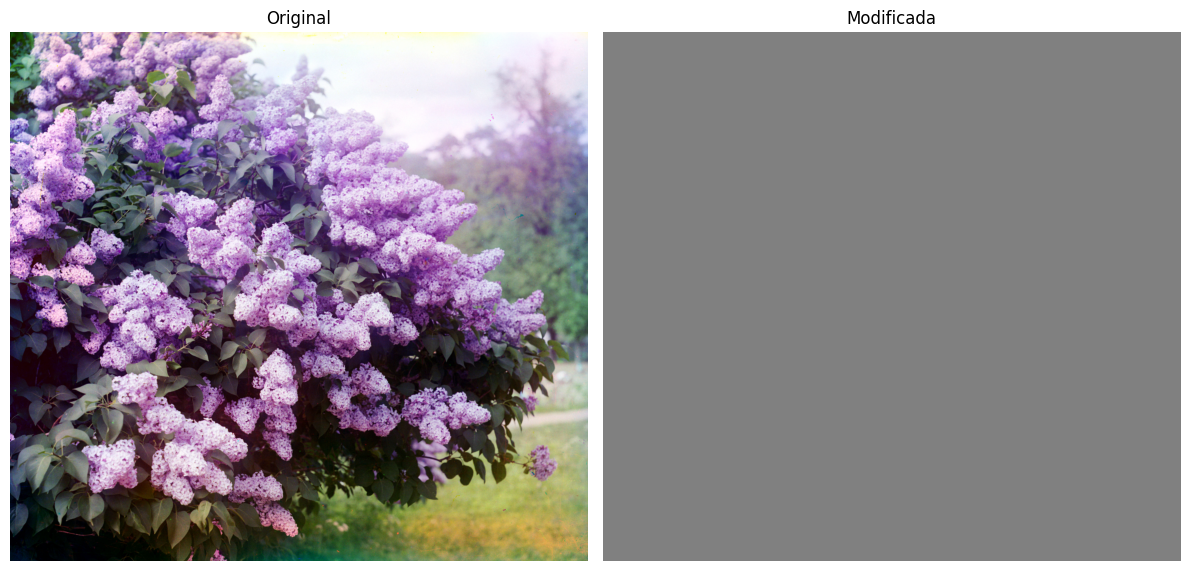

In [22]:
# Create a diagonal embossing kernel
kernel = np.array([[-1, 0, 1]])

# 1. Apply a horizontal filter to capture horizontal changes
img_resulth = linear_filter(img=img, kernel_horizontal=kernel, convert_color_func=bgr_to_gray)

# 2. Apply a vertical filter to capture vertical changes
img_resultv = linear_filter(img=img, kernel_vertical=kernel, convert_color_func=bgr_to_gray)

# 3. Combine the results
combined_emboss = img_resulth + img_resultv

# 4. Add a constant value to shift the gray midpoint and make it visible
img_embossed = np.clip(combined_emboss + 128, 0, 255)

show_diff(img, img_embossed)

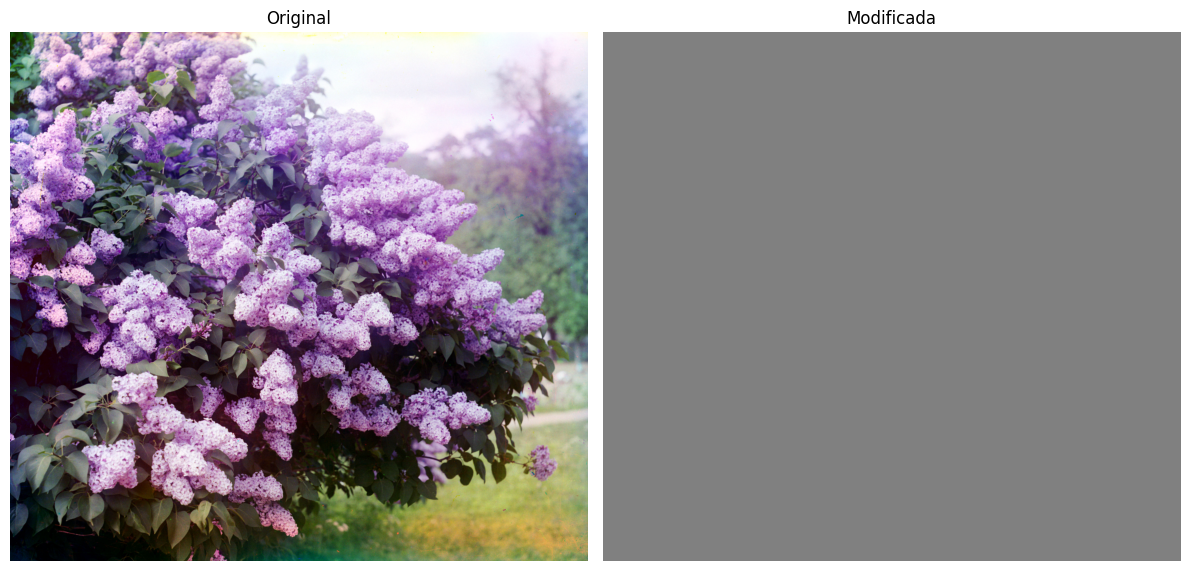

In [23]:
# A simple 1D kernel for ridge detection
# It responds to a pattern of low-high-low or high-low-high intensity
ridge_kernel = np.array([[1, -2, 1]])

# Apply the filter in both horizontal and vertical directions
# Convert to grayscale first for a better result
img_result_h = linear_filter(img=img, kernel_horizontal=ridge_kernel, convert_color_func=bgr_to_gray)
img_result_v = linear_filter(img=img, kernel_vertical=ridge_kernel, convert_color_func=bgr_to_gray)

# Sum the results
combined_ridges = img_result_h + img_result_v

# Normalize and convert back to a visible range
normalized_ridges = np.clip(combined_ridges + 128, 0, 255)

show_diff(img, normalized_ridges.astype(np.uint8))

In [24]:
def gaussian_vector_1d(kernel_size, sigma):
    """Gera um vetor 1D gaussiano normalizado"""
    half_size = kernel_size // 2
    x = np.arange(-half_size, half_size + 1)
    g = np.exp(-(x**2) / (2 * sigma**2))
    g = g / g.sum()  
    return np.array([g])

In [25]:
def dog(img, kernel_size=5, sigma=1.0, k=2.0, t=0.5, e=0.5, phi=1.0, show=False, convert_color_func=bgr_to_gray):
    g5_1 = gaussian_vector_1d(kernel_size=kernel_size, sigma=sigma)
    g5_2 = gaussian_vector_1d(kernel_size=kernel_size, sigma=sigma * k)
    
    img1 = linear_filter(img, kernel_horizontal=g5_1, kernel_vertical=g5_1, convert_color_func=convert_color_func, normalized=False)
    img2 = linear_filter(img, kernel_horizontal=g5_2, kernel_vertical=g5_2, convert_color_func=convert_color_func, normalized=False)
    diff = np.clip((1 + t)*img1 - t * img2, 0.0, 1.0)
    if show: show_diff(img1, img2)

    diff = np.where(diff > e, 1.0, 1 + np.tanh(phi * (diff - e)))
    # diff = np.where(diff > e, 1.0, 0.0)
    return diff


In [39]:
img_bia = cv2.imread('fotos/galo.png').astype(np.float32) / 255.0   
# img_bia = cv2.imread('fotos/bia.png').astype(np.float32) / 255.0  
e = 0.3
phi = 1.3
t = 70
sigma = 0.25
kernel_size=5
img_bia = cv2.imread('fotos/estatua.jpg').astype(np.float32) / 255.0  
img_bia = cv2.imread('fotos/IMG_ajustada.JPG').astype(np.float32) / 255.0  
# img_bia = cv2.imread('fotos/eu.jpg').astype(np.float32) / 255.0  



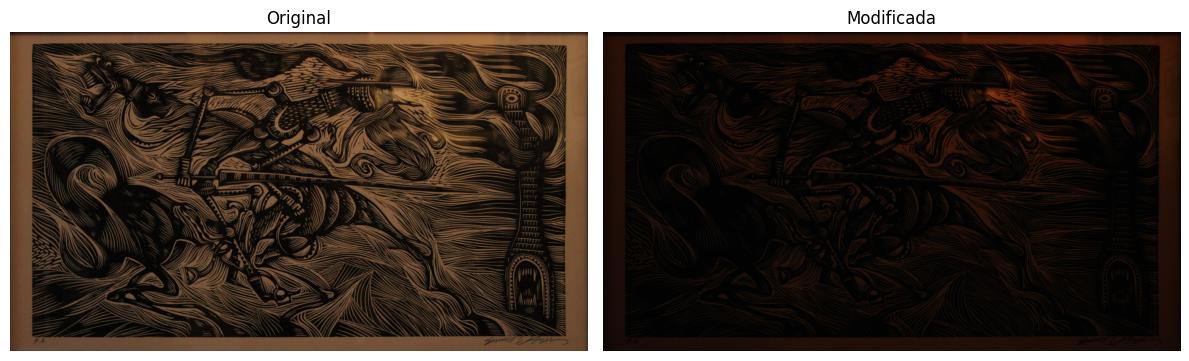

In [42]:
e = 0.9
phi = 3
t = 0.1
sigma = 0.25
kernel_size=5
# dog_img = dog(img_bia, kernel_size=kernel_size, sigma=sigma, k=10, t=t, e=e, phi=phi, show=False, convert_color_func=bgr_to_gray)
# show_diff(img_bia, compose(dog_img, bgr_to_gray(img_bia), a=3.0))

cv2.imwrite('outputs/estatua.jpg', np.clip(dog_img * 255, 0, 255))
dog_img = dog(img_bia, kernel_size=kernel_size, sigma=sigma, k=10, t=t, e=e, phi=phi, show=False, convert_color_func=None)
show_diff(img_bia, dog_img)

In [ ]:
# cap = cv2.VideoCapture(0)
# e = 0.3
# phi = 10
# t = 40
# sigma = 0.07
# kernel_size=10
# k=10
# if not cap.isOpened():
#     print("Cannot open camera")
#     exit()
# while True:
#     # Capture frame-by-frame
#     ret, frame = cap.read()
 
#     # if frame is read correctly ret is True
#     if not ret:
#         print("Can't receive frame (stream end?). Exiting ...")
#         break
#     # Our operations on the frame come here
#     # gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
#     dog_img = dog(frame,kernel_size=kernel_size,sigma=sigma,k=k,t=t,e=e,phi=phi, convert_color_func=bgr_to_gray)
#     # Display the resulting frame
#     cv2.imshow('frame', dog_img)
#     if cv2.waitKey(1) == ord('q'):
#         break
 
# # When everything done, release the capture
# cap.release()
# cv2.destroyAllWindows()